# Rocket

## Environment Definition

In [1]:
import logging
import warnings

import numpy as np

from do_ddpc.environments.rocket_env.rocket_env_facade import RocketEnvironmentArguments, RocketEnvFacade

# Removes the INFO logging
logging.getLogger().setLevel(logging.WARNING)
# Suppress all UserWarnings
warnings.filterwarnings("ignore", category=UserWarning)

data_col_env = RocketEnvFacade(RocketEnvironmentArguments(), video_name_prefix="data_collection", record_video=True)

In [2]:
from pyvirtualdisplay import Display

# create display for the videos
display = Display(visible=False, size=(1400, 900), backend="xvfb")
display.start()

## Training Data Collection

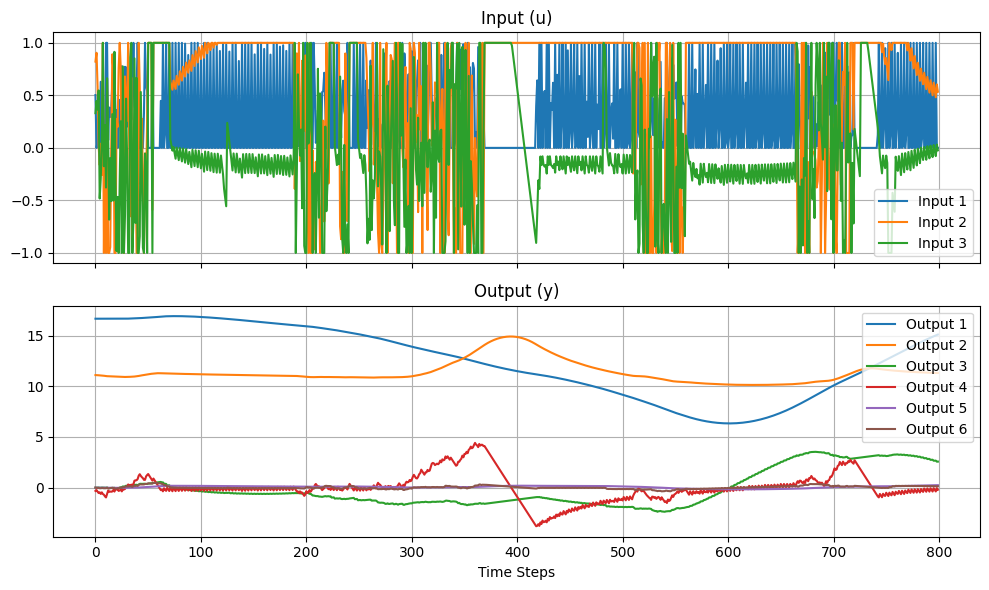

In [3]:
from do_ddpc.environments.rocket_env.rocket_data_collection import collect_trajectory_data_env
from do_ddpc.utils.plots import plot_training_data

n_samples = 800

m, p = data_col_env.get_dims()
training_data = collect_trajectory_data_env(data_col_env, m, p, n_samples=n_samples)
data_col_env.close()

plot_training_data(training_data)

In [4]:
from do_ddpc.utils.plots import show_video

show_video("data_collection")

## Online DPC Application

In [5]:
from do_ddpc.control_utils.trajectory_collector import TrajectoryCollector
from do_ddpc.environments.rocket_env.rocket_utils import calculate_normalized_thrust_to_hover
from do_ddpc.environments.rocket_env.rocket_controller_profiles import CTRL_PARAMS_ROCKET
from do_ddpc.ddpc.tpc import TPC

env = RocketEnvFacade(
    RocketEnvironmentArguments(initial_position=(0.8, 0.9, 0)), video_name_prefix="rocket_example", record_video=True
)
m, p = env.get_dims()

n_sim = 2000

traj_col = TrajectoryCollector(m, p, n_sim)

controller_instance = TPC(CTRL_PARAMS_ROCKET, training_data)
controller_instance.add_input_constraints(env.get_input_bounds())
controller_instance.build_optimization_problem()

TIMESTEPS = 2000
u_stable = np.array([calculate_normalized_thrust_to_hover(), 0, 0])

u_next, y_current, y_prev = u_stable, env.get_output(), env.get_output()
z_p_current = np.concatenate((y_prev, u_next))

for _ in range(CTRL_PARAMS_ROCKET.tau_p):
    controller_instance.update_past_measurements(z_p_current)
y_prev = env.step(u_next)
try:
    for i in range(TIMESTEPS):
        if env.landed_successfully:
            print(f"Landed successfully after {i} steps")
            break

        if env.done:
            print(f"Crashed after {i} steps")
            break

        y_r, u_r = env.get_y_u_reference()
        controller_instance.update_tracking_reference(y_r, u_r)

        traj_col.store_measurements(y_prev, u_next)
        z_p_current = np.concatenate((y_prev, u_next))
        controller_instance.update_past_measurements(z_p_current)

        controller_instance.solve()
        u_next = controller_instance.get_next_control_action()
        y_prev, y_current = y_current, env.step(u_next)

finally:
    assert env.landed_successfully, "Rocket did not land successfully!"
    env.close()

sim_data = traj_col.get_trajectory_data()

2025-03-31 10:56:23,380 - WARNING - do_ddpc.ddpc.tpc - Lambda_uu is not positive semidefinite. Regularization cost is skipped to avoid non-convex cost.
Landed successfully after 1287 steps
2025-03-31 10:56:48,449 - WARNING - do_ddpc.control_utils.trajectory_collector - NaN values detected in trajectory data. Cleaning data by removing NaNs.


## Analyse and Data Visualization

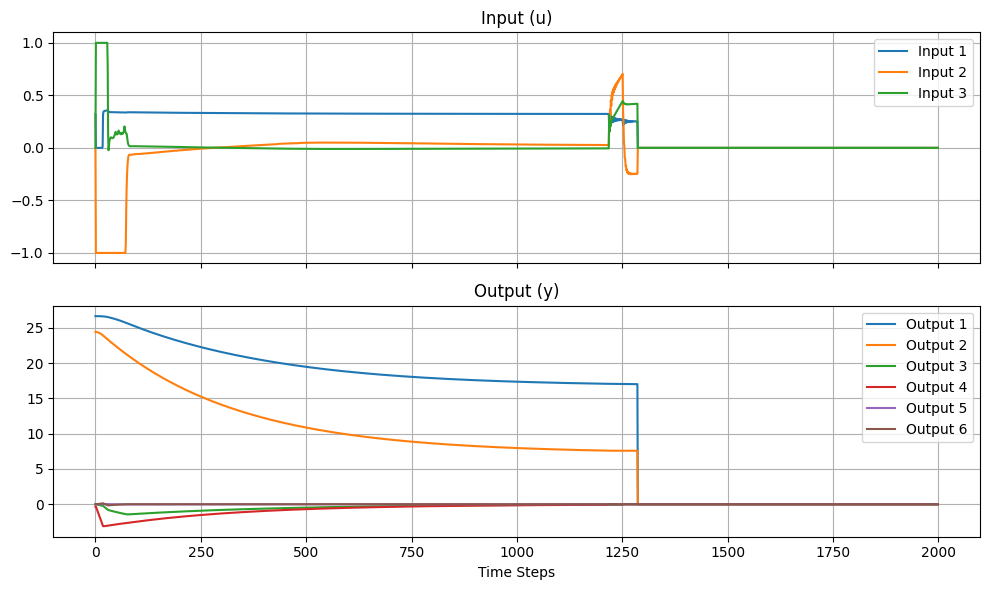

In [6]:
plot_training_data(sim_data)

In [7]:
show_video("rocket_example")